In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from os import path
import copy 

from chemprop.features import BatchMolGraph, MolGraph
from chemprop.data.data import MoleculeDatapoint, MoleculeDataset
from chemprop.data import MoleculeDataLoader, split_data
from chemprop.nn_utils import get_activation_function, initialize_weights, NoamLR
import torch
from chemprop.utils import build_lr_scheduler
from torch.nn.parameter import Parameter
td = torch.distributions
from chemprop.args import TrainArgs, HyperoptArgs
from chemprop.features.featurization import get_atom_fdim, get_bond_fdim
from tqdm import tqdm
from chemprop.train import cross_validate, run_training
from chemprop.models.model import LangvianMoleculeModel
from chemprop.features.featurization import BatchMolGraph
from torch.optim.lr_scheduler import _LRScheduler
from chemprop.data import get_data

In [2]:
class BayesianArgs(TrainArgs):
    prior = td.Normal(0,1)
    data_path = "data/leo_sulphamides_JAKs.csv"
    init = 'zeros' 
    init_lr = 1e-5#1e-5  #5e-3
    max_lr = 1e-3   #1e-2
    final_lr = 1e-4 #1e-5
    split_sizes = (0.8, 0.1, 0.1)
    train_data_size = 642*split_sizes[0] #9880*split_sizes[0]
    epochs = 1000
    warmup_epochs = 2

args = BayesianArgs()
if args.data_path == "data/zinc250k.csv":
    args.num_tasks = 3
elif args.data_path == "data/leo_sulphamides.csv":
    args.num_tasks = 5
elif args.data_path == "data/leo_sulphamides_JAKs.csv":
    args.num_tasks = 3
else:
    args.num_tasks = 1
args.ffn_hidden_size = 100
args.hidden_size = 100
args.ffn_num_layers = 3
args.depth = 6
args.dropout = 0.0# # Changed from 0.15
args.num_workers = 0
args.batch_size = 40 #200 # Changed from 50
args.dataset_type = 'regression'
args.device = torch.device('cuda')

/zhome/17/6/118138/anaconda3/envs/chemprop/lib/python3.8/site-packages/tap/tap.py:304: UserWarning: add_arguments is deprecated and will be removed on January 1st, 2021 please override "configure" instead and call add_argument there. 
  warn('add_arguments is deprecated and will be removed on January 1st, 2021'


In [3]:
load_trained = True
mod = LangvianMoleculeModel(args)

path_name = args.data_path.partition("/")[2].partition(".")[0]
path_name += "_LANGEVIN"
path_name += f"_hidden_{args.ffn_hidden_size}"
path_name += f"_ffn_num_{args.ffn_num_layers}"
path_name += f"_depth_{args.depth}"
path_name += f"_dropout_{args.dropout}"
path_name += f"_epochs_{args.epochs}"

mod.load_state_dict(torch.load("31-12-2020_leo_sulphamides_JAKs_LANGEVIN_hidden_100_ffn_num_3_depth_6_dropout_0.0_epochs_2000"))

<All keys matched successfully>

In [4]:
# Number of parameter objects in mod (2*3 for MPN, 2*2*(ffm_num_layers-1) for FFN, 2*2 for FFN_mean, 2*2 for FFN_std)
print("Number of params", len([param for param in mod.parameters()]))
num_params = 0
for name, param in mod.named_parameters():
    if len(param.shape) > 1:
        num_params += param.shape[0] * param.shape[1]
    else:
        num_params += len(param)
    
print("Total number of weights", num_params)

Number of params 15
Total number of weights 79106


In [5]:
data = get_data(path=args.data_path, args=args, skip_none_targets=True)
train_data, val_data, test_data = split_data(data=data, 
                                             split_type=args.split_type, 
                                             sizes=args.split_sizes, 
                                            # seed=args.seed, 
                                             num_folds=args.num_folds, 
                                             args=args, 
                                             logger=None)

862it [00:00, 155137.96it/s]
100%|██████████| 862/862 [00:00<00:00, 2310.17it/s]


In [6]:
# Standardise train/val/test sets by training set's mean/std
targets_train_np = np.array(train_data.targets())
targets_val_np = np.array(val_data.targets())
targets_test_np = np.array(test_data.targets())
#print(targets_train_np)
y_mean_train = np.mean(targets_train_np, axis=0)
y_std_train = np.std(targets_train_np, axis=0)
targets_train_np = (targets_train_np - y_mean_train)/y_std_train
targets_val_np = (targets_val_np - y_mean_train)/y_std_train
targets_test_np = (targets_test_np - y_mean_train)/y_std_train

train_data.set_targets(targets_train_np)
val_data.set_targets(targets_val_np)
test_data.set_targets(targets_test_np)

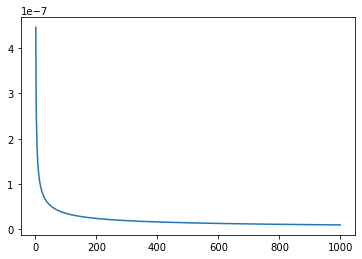

In [7]:
gamma =torch.tensor(0.55)
hi,lo = 1e-5, 1e-8
max_lr = torch.tensor(hi) #torch.tensor(1.3243e-06)#torch.tensor(1.0e-9)
min_lr = torch.tensor(lo) #torch.tensor(9.0e-7)#torch.tensor(1.0e-11)
T = torch.tensor(args.epochs)

k = (min_lr/max_lr)**(1/gamma)

b = k*T/(1-k)
a = max_lr*b**(gamma)

t_range = np.arange(1, args.epochs)
plt.plot(t_range, a * (b + t_range) ** (-gamma))
StandardNormal = td.normal.Normal(loc=0, scale=1)

In [8]:
!nvidia-smi
torch.cuda.set_device(3)

Sun Jan  3 15:31:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 455.23.05    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   29C    P0    43W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:16:00.0 Off |                    0 |
| N/A   

In [ ]:
#!kill 4446

In [11]:
def train(model: LangvianMoleculeModel,
          data_loader: MoleculeDataLoader,
          optimizer,
          args: TrainArgs,
          n_iter, 
          n_ADAM) -> int:
    """
    Trains a model for an epoch.

    :param model: A :class:`~chemprop.models.model.MoleculeModel`.
    :param data_loader: A :class:`~chemprop.data.data.MoleculeDataLoader`.
    :param loss_func: Loss function.
    :param optimizer: An optimizer.
    :param args: A :class:`~chemprop.args.TrainArgs` object containing arguments for training the model.
    :param n_iter: The number of iterations (training examples) trained on so far.
    :return: The total number of iterations (training examples) trained on so far.
    """
    model.to(device)
    model.train()
    loss_sum = iter_count = 0
    num_batches = len(data_loader)
    
    for t, batch in enumerate(tqdm(data_loader, total=len(data_loader), leave=False, disable=True)):
        #print("Iteration", t)
        # Prepare batch
        batch: MoleculeDataset
        mol_batch, features_batch, target_batch, atom_descriptors_batch = \
            batch.batch_graph(), batch.features(), batch.targets(), batch.atom_descriptors()
        
        target_batch = torch.Tensor(target_batch)
        target_batch = target_batch.to(device)
        
        # Run model
        model.zero_grad()
        ll = model.sum_ll(mol_batch[0], target_batch) 
        prior_loss = model.prior_loss()
        loss = num_batches*ll + prior_loss
        loss_sum += loss
        
        if torch.isnan(loss): 
            print(ll, prior_loss)
            assert False, "breakpoint"
        
        #Epsilon defined 
        eps_t = a * (b + t+num_batches*(n_iter-n_ADAM)) ** (-gamma)
        
        if n_iter <=n_ADAM: #First epocs are trained using adam. 
            loss = -loss
            loss.backward()
            optimizer.step()
            #if isinstance(scheduler, NoamLR):  
            #    scheduler.step()
        else: #Langevin step.
            loss.backward()
            with torch.no_grad(): #In order to update parameters manually. 
                for name, p in model.named_parameters():
                    #Sample eta hver gang. 
                    if p.grad is not None:
                        eta_t = td.Normal(loc=0, scale=np.sqrt(eps_t)).sample(sample_shape=p.size()).cuda()
                        new_val = p + eps_t/2 * (p.grad) + eta_t
                        p.copy_(new_val)


    return loss_sum / num_batches, eps_t

def get_val_loss(model: LangvianMoleculeModel,
          data_loader: MoleculeDataLoader,
          args: TrainArgs):
    num_batches = len(data_loader)
    loss_sum = 0.0
    
    for b, batch_val in enumerate(tqdm(data_loader, total=len(data_loader), leave=False, disable=True)):
        mol_batch, features_batch, target_batch, atom_descriptors_batch = \
            batch_val.batch_graph(), batch_val.features(), batch_val.targets(), batch_val.atom_descriptors()
        target_batch = torch.Tensor(target_batch).to(device)
        with torch.no_grad():
            ll = mod.sum_ll(mol_batch[0], target_batch) 
            prior_loss = mod.prior_loss()
            loss = num_batches*ll + prior_loss 
        loss_sum += loss.item()
    return loss_sum / num_batches

In [13]:
device = args.device
epochs = args.epochs
optimizer = torch.optim.Adam(mod.parameters(),lr=1e-3) #Only used for checking that manually updating parameters work
scheduler = build_lr_scheduler(optimizer, args)
train_data_loader = MoleculeDataLoader(dataset=train_data,
                                       batch_size=args.batch_size,
                                       num_workers=args.num_workers,
                                       class_balance=args.class_balance,
                                       shuffle=True,
                                       seed=args.seed)
val_data_loader = MoleculeDataLoader(dataset=val_data,batch_size=args.batch_size,num_workers=args.num_workers)
test_data_loader = MoleculeDataLoader(dataset=test_data,batch_size=len(test_data),num_workers=args.num_workers)

SavedParameters = []
n_ADAM = 0

if "loss_lst" or "loss_val" not in globals():
    loss_lst = []
    loss_val = []
    
for n_iter in range(epochs):
    
    loss_sum, eps2 = train(model=mod,
                   data_loader=train_data_loader,
                   optimizer=optimizer,
                   args=args,
                   n_iter=n_iter, 
                    n_ADAM= n_ADAM)
    loss_lst.append(loss_sum)
    
    # Validation 
    mod.eval()
    loss = get_val_loss(mod, val_data_loader, args)
    loss_val.append(loss)
    
    if n_iter>n_ADAM: #Saving langevin parameters
        SavedParameters.append(copy.deepcopy(mod.state_dict()))
    
    print(f"Epoch {n_iter+1} loss {loss_sum}, val loss {loss}, eta std {np.sqrt(eps2)}")

Epoch 1 loss -70997.2265625, val loss -72618.8359375, eta std 0.00030662131030112505
Epoch 2 loss -72416.0390625, val loss -72616.9453125, eta std 0.0002514026127755642
Epoch 3 loss -71123.8515625, val loss -72646.484375, eta std 0.0002242935006506741
Epoch 4 loss -71128.046875, val loss -72630.27864583333, eta std 0.0002069657639367506
Epoch 5 loss -71093.125, val loss -72621.7109375, eta std 0.00019449726096354425
Epoch 6 loss -71030.5234375, val loss -72630.3359375, eta std 0.00018489110516384244
Epoch 7 loss -70970.2578125, val loss -72617.6171875, eta std 0.0001771523238858208
Epoch 8 loss -70959.9921875, val loss -72624.33072916667, eta std 0.00017071831098292023
Epoch 9 loss -70939.109375, val loss -72628.34375, eta std 0.000165242119692266
Epoch 10 loss -70911.171875, val loss -72625.11197916667, eta std 0.00016049575060606003
Epoch 11 loss -70927.125, val loss -72623.96354166667, eta std 0.0001563219993840903
Epoch 12 loss -70904.8828125, val loss -72639.37239583333, eta std 0

Epoch 96 loss -70874.4453125, val loss -72617.5546875, eta std 8.604879985796288e-05
Epoch 97 loss -70867.75, val loss -72613.5390625, eta std 8.580378926126286e-05
Epoch 98 loss -70878.875, val loss -72624.5625, eta std 8.556198008591309e-05
Epoch 99 loss -70878.2890625, val loss -72627.51041666667, eta std 8.532329957233742e-05
Epoch 100 loss -70878.6171875, val loss -72620.5625, eta std 8.508766768500209e-05
Epoch 101 loss -70866.7265625, val loss -72625.3359375, eta std 8.48550334922038e-05
Epoch 102 loss -70882.1640625, val loss -72616.6328125, eta std 8.46253169584088e-05
Epoch 103 loss -70884.9765625, val loss -72623.6953125, eta std 8.439845259999856e-05
Epoch 104 loss -70869.765625, val loss -72621.3125, eta std 8.417438220931217e-05
Epoch 105 loss -70868.703125, val loss -72624.61979166667, eta std 8.39530403027311e-05
Epoch 106 loss -70869.140625, val loss -72619.546875, eta std 8.373437594855204e-05
Epoch 107 loss -70873.2265625, val loss -72616.81770833333, eta std 8.35183

Epoch 191 loss -70860.640625, val loss -72602.734375, eta std 7.121163798728958e-05
Epoch 192 loss -70876.703125, val loss -72603.33072916667, eta std 7.110941805876791e-05
Epoch 193 loss -70870.59375, val loss -72601.88020833333, eta std 7.100787479430437e-05
Epoch 194 loss -70869.734375, val loss -72604.50260416667, eta std 7.090700819389895e-05
Epoch 195 loss -70865.3359375, val loss -72600.41927083333, eta std 7.080678915372118e-05
Epoch 196 loss -70872.34375, val loss -72605.9453125, eta std 7.070723222568631e-05
Epoch 197 loss -70863.78125, val loss -72599.3984375, eta std 7.060831558192149e-05
Epoch 198 loss -70860.578125, val loss -72605.2265625, eta std 7.051004649838433e-05
Epoch 199 loss -70860.6328125, val loss -72607.16145833333, eta std 7.041240314720199e-05
Epoch 200 loss -70869.0234375, val loss -72610.56770833333, eta std 7.031537825241685e-05
Epoch 201 loss -70862.625, val loss -72606.76822916667, eta std 7.021897908998653e-05
Epoch 202 loss -70870.5078125, val loss -

Epoch 285 loss -70852.4140625, val loss -72606.19791666667, eta std 6.378834950737655e-05
Epoch 286 loss -70858.4296875, val loss -72614.61979166667, eta std 6.372692587319762e-05
Epoch 287 loss -70853.578125, val loss -72608.57552083333, eta std 6.366577872540802e-05
Epoch 288 loss -70851.03125, val loss -72601.84375, eta std 6.360489351209253e-05
Epoch 289 loss -70865.703125, val loss -72608.38541666667, eta std 6.354428478516638e-05
Epoch 290 loss -70855.0859375, val loss -72611.25, eta std 6.348393799271435e-05
Epoch 291 loss -70868.5703125, val loss -72609.07291666667, eta std 6.342386041069403e-05
Epoch 292 loss -70857.25, val loss -72605.09635416667, eta std 6.336404476314783e-05
Epoch 293 loss -70854.71875, val loss -72610.53125, eta std 6.330448377411813e-05
Epoch 294 loss -70851.1328125, val loss -72608.3828125, eta std 6.324518471956253e-05
Epoch 295 loss -70867.5390625, val loss -72606.04947916667, eta std 6.318614759948105e-05
Epoch 296 loss -70862.1484375, val loss -72608

Epoch 379 loss -70844.6015625, val loss -72615.4609375, eta std 5.897829032619484e-05
Epoch 380 loss -70848.0703125, val loss -72619.109375, eta std 5.893555862712674e-05
Epoch 381 loss -70838.8671875, val loss -72624.28385416667, eta std 5.889297608518973e-05
Epoch 382 loss -70858.5703125, val loss -72623.28385416667, eta std 5.885053178644739e-05
Epoch 383 loss -70843.421875, val loss -72621.87760416667, eta std 5.880822936887853e-05
Epoch 384 loss -70856.7890625, val loss -72621.8203125, eta std 5.876606883248314e-05
Epoch 385 loss -70843.2421875, val loss -72614.10677083333, eta std 5.872405017726123e-05
Epoch 386 loss -70844.0703125, val loss -72616.65364583333, eta std 5.8682166127255186e-05
Epoch 387 loss -70842.7578125, val loss -72617.21614583333, eta std 5.864042032044381e-05
Epoch 388 loss -70846.015625, val loss -72616.87239583333, eta std 5.859881639480591e-05
Epoch 389 loss -70847.71875, val loss -72617.8828125, eta std 5.855734343640506e-05
Epoch 390 loss -70849.1484375,

Epoch 473 loss -70836.2109375, val loss -72630.16927083333, eta std 5.549165507545695e-05
Epoch 474 loss -70831.96875, val loss -72631.734375, eta std 5.545942985918373e-05
Epoch 475 loss -70837.125, val loss -72629.4140625, eta std 5.542729559238069e-05
Epoch 476 loss -70838.109375, val loss -72633.78385416667, eta std 5.539524499909021e-05
Epoch 477 loss -70836.0390625, val loss -72641.20833333333, eta std 5.53632817172911e-05
Epoch 478 loss -70841.21875, val loss -72636.328125, eta std 5.533140210900456e-05
Epoch 479 loss -70831.53125, val loss -72640.10677083333, eta std 5.5299606174230576e-05
Epoch 480 loss -70832.1953125, val loss -72641.77864583333, eta std 5.5267897550947964e-05
Epoch 481 loss -70837.140625, val loss -72655.49739583333, eta std 5.5236272601177916e-05
Epoch 482 loss -70838.1640625, val loss -72661.59375, eta std 5.520473132492043e-05
Epoch 483 loss -70835.4453125, val loss -72652.8984375, eta std 5.51732700841967e-05
Epoch 484 loss -70841.4765625, val loss -7265

Epoch 567 loss -70835.578125, val loss -72633.1328125, eta std 5.279305696603842e-05
Epoch 568 loss -70824.7265625, val loss -72626.98697916667, eta std 5.276747833704576e-05
Epoch 569 loss -70830.0390625, val loss -72632.58854166667, eta std 5.274195791571401e-05
Epoch 570 loss -70828.7265625, val loss -72622.9453125, eta std 5.2716495702043176e-05
Epoch 571 loss -70818.984375, val loss -72624.0859375, eta std 5.269108805805445e-05
Epoch 572 loss -70826.796875, val loss -72621.15885416667, eta std 5.2665734983747825e-05
Epoch 573 loss -70826.6484375, val loss -72616.33333333333, eta std 5.2640440117102116e-05
Epoch 574 loss -70832.5703125, val loss -72620.078125, eta std 5.261520345811732e-05
Epoch 575 loss -70827.2265625, val loss -72621.375, eta std 5.259002136881463e-05
Epoch 576 loss -70832.1015625, val loss -72620.71875, eta std 5.256489384919405e-05
Epoch 577 loss -70829.09375, val loss -72631.53385416667, eta std 5.253982453723438e-05
Epoch 578 loss -70831.4609375, val loss -72

Epoch 660 loss -70825.265625, val loss -72617.74739583333, eta std 5.063326534582302e-05
Epoch 661 loss -70829.625, val loss -72620.65885416667, eta std 5.061218689661473e-05
Epoch 662 loss -70833.5, val loss -72630.8359375, eta std 5.059114846517332e-05
Epoch 663 loss -70827.59375, val loss -72623.5859375, eta std 5.057015368947759e-05
Epoch 664 loss -70824.1875, val loss -72626.7578125, eta std 5.054919529356994e-05
Epoch 665 loss -70827.1484375, val loss -72622.67447916667, eta std 5.052827691542916e-05
Epoch 666 loss -70820.65625, val loss -72625.65364583333, eta std 5.050739855505526e-05
Epoch 667 loss -70827.2578125, val loss -72619.04947916667, eta std 5.0486567488405854e-05
Epoch 668 loss -70825.9296875, val loss -72622.0703125, eta std 5.04657655255869e-05
Epoch 669 loss -70828.4140625, val loss -72613.2109375, eta std 5.0445010856492445e-05
Epoch 670 loss -70825.640625, val loss -72613.1640625, eta std 5.042428892920725e-05
Epoch 671 loss -70823.96875, val loss -72615.0859375

Epoch 755 loss -70829.484375, val loss -72640.13541666667, eta std 4.8794834583532065e-05
Epoch 756 loss -70827.421875, val loss -72643.32291666667, eta std 4.8777073970995843e-05
Epoch 757 loss -70843.734375, val loss -72637.70572916667, eta std 4.8759346100268885e-05
Epoch 758 loss -70829.390625, val loss -72638.09895833333, eta std 4.8741647333372384e-05
Epoch 759 loss -70833.8515625, val loss -72647.15104166667, eta std 4.872397767030634e-05
Epoch 760 loss -70833.21875, val loss -72642.30729166667, eta std 4.870633711107075e-05
Epoch 761 loss -70831.328125, val loss -72651.06510416667, eta std 4.868872565566562e-05
Epoch 762 loss -70832.40625, val loss -72641.3046875, eta std 4.8671146942069754e-05
Epoch 763 loss -70832.3203125, val loss -72642.41666666667, eta std 4.8653593694325536e-05
Epoch 764 loss -70827.84375, val loss -72633.94270833333, eta std 4.863607318839058e-05
Epoch 765 loss -70831.34375, val loss -72635.4609375, eta std 4.861857814830728e-05
Epoch 766 loss -70830.539

Epoch 848 loss -70820.9140625, val loss -72623.22135416667, eta std 4.726062252302654e-05
Epoch 849 loss -70823.234375, val loss -72621.5625, eta std 4.7245306632248685e-05
Epoch 850 loss -70820.046875, val loss -72623.94010416667, eta std 4.723001620732248e-05
Epoch 851 loss -70817.59375, val loss -72626.3125, eta std 4.721474397229031e-05
Epoch 852 loss -70825.2265625, val loss -72624.19791666667, eta std 4.7199497203109786e-05
Epoch 853 loss -70819.84375, val loss -72629.87239583333, eta std 4.718427226180211e-05
Epoch 854 loss -70820.8828125, val loss -72630.9921875, eta std 4.716907278634608e-05
Epoch 855 loss -70822.140625, val loss -72630.86979166667, eta std 4.715389513876289e-05
Epoch 856 loss -70821.390625, val loss -72630.8359375, eta std 4.713873568107374e-05
Epoch 857 loss -70819.7109375, val loss -72628.65885416667, eta std 4.7123605327215046e-05
Epoch 858 loss -70822.484375, val loss -72631.0234375, eta std 4.710849316325039e-05
Epoch 859 loss -70824.8984375, val loss -7

Epoch 942 loss -70828.265625, val loss -72708.13541666667, eta std 4.591382821672596e-05
Epoch 943 loss -70830.609375, val loss -72703.26041666667, eta std 4.5900436816737056e-05
Epoch 944 loss -70831.9765625, val loss -72686.63541666667, eta std 4.588705633068457e-05
Epoch 945 loss -70826.203125, val loss -72687.15885416667, eta std 4.587369767250493e-05
Epoch 946 loss -70826.765625, val loss -72691.3671875, eta std 4.5860357204219326e-05
Epoch 947 loss -70824.53125, val loss -72706.4921875, eta std 4.584703128784895e-05
Epoch 948 loss -70828.9296875, val loss -72699.85416666667, eta std 4.5833727199351415e-05
Epoch 949 loss -70823.046875, val loss -72714.17447916667, eta std 4.582044493872672e-05
Epoch 950 loss -70830.5390625, val loss -72719.32291666667, eta std 4.5807169954059646e-05
Epoch 951 loss -70831.296875, val loss -72706.40364583333, eta std 4.579391679726541e-05
Epoch 952 loss -70832.46875, val loss -72715.59895833333, eta std 4.578068546834402e-05
Epoch 953 loss -70828.59

Text(0.5, 1.0, 'LEO JAKs')

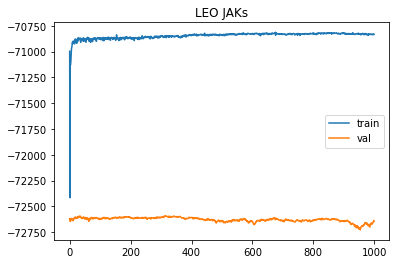

In [14]:
plt.clf()
plt.plot(np.asarray(loss_lst))
plt.plot(np.asarray(loss_val))
plt.legend(['train', 'val'])
plt.title("LEO JAKs")

## Sample from posterior (i.e. get latest weights in SavedParameters)

In [170]:
batch = next(iter(test_data_loader)) #All test data
mol_batch, features_batch, target_batch, atom_descriptors_batch = \
            batch.batch_graph(), batch.features(), batch.targets(), batch.atom_descriptors()

y2_pred_mean = [] #Size (#samples, #testpoints)  
y2_pred_std =  [] #Size (#samples, #testpoints)

for i in range(len(SavedParameters)-950,len(SavedParameters)-800): #the interval where it looks that the 
    mod.load_state_dict(SavedParameters[i])
    y_pred_mean, y_pred_rho = mod.forward(mol_batch[0])
    y_pred_mean = y_pred_mean.detach()
    y_pred_rho = y_pred_rho.detach()
    y_pred_std =  mod.softplus(y_pred_rho) + mod.eps
    
    y2_pred_mean.append(y_pred_mean)
    y2_pred_std.append(y_pred_std)

## Functions for plotting output distribution

In [171]:
from scipy.stats import norm

def PlotFunction(par, amount):

    fig=plt.figure(figsize=(16, 64))
    fig.tight_layout()


    columns = 2
    rows = 32
    for index in range(amount):
        y1 = []
        y2 = []
        for i in range(len(y2_pred_std)):
            y1.append(y2_pred_mean[i][index][par].item())
            y2.append(y2_pred_std[i][index][par].item())

        if index == 0:
            ax1 = fig.add_subplot(rows, columns, index+1)
        else:
            fig.add_subplot(rows, columns, index+1, sharex = None)

        yytest = np.array(target_batch[index][par])
        plt.hist(y1, bins = 20,weights=[1/50]*len(y1),color='black',alpha = 0.5 )
        plt.axvline(x=yytest, color='r', linestyle='dashed', linewidth=2)

        x_axis = np.arange(min(min(y1),yytest)-0.1,max(max(y1),yytest)+0.1 , 0.001)

        for i in range(len(y2_pred_std)):
            STD = np.sqrt(np.std(y1, axis=0)**2+np.mean(np.array(y2)**2)) 
            RMSE = np.sqrt(np.mean((y1-yytest)**2))

            p2 = plt.plot(x_axis, norm.pdf(x_axis,y1[i],y2[i]), 'b-',alpha = 0.03, label = "$\sqrt{E(\sigma^2)}$"+f" {STD:.2f} \nRMSE  {RMSE:.2f}\nIndex {index}")

        plt.legend(handles = p2,loc='upper left')

    plt.show()

JAK1


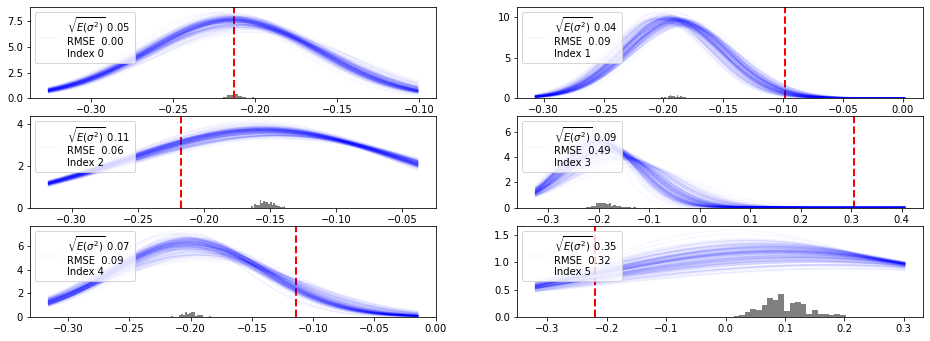

JAK2


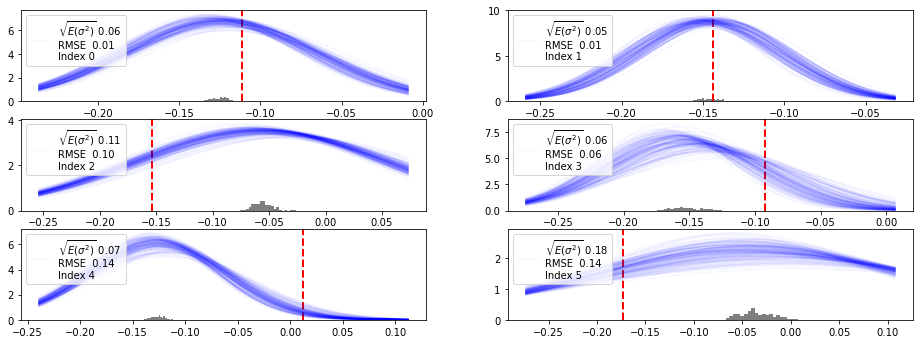

JAK3


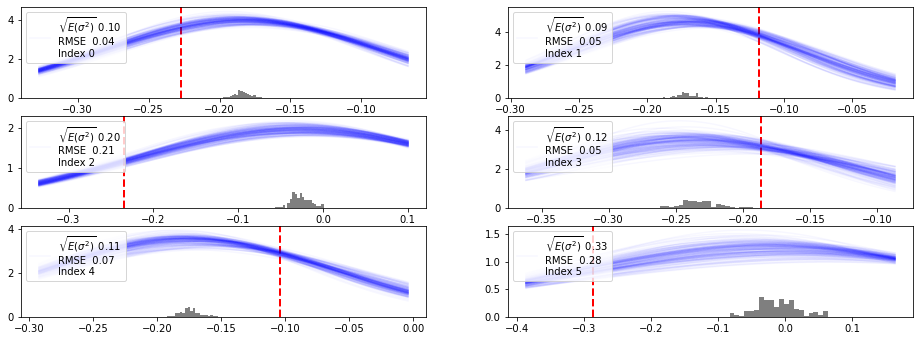

In [172]:
print("JAK1")
PlotFunction(0, 6)
print("JAK2")
PlotFunction(1, 6)
print("JAK3")
PlotFunction(2, 6)

## Uncertainty quantification quality test (Calibration measure)

### Functions

In [173]:
def ENCE(sigma, rmse):
    return np.mean(np.abs(sigma - rmse) / sigma)

In [174]:
def plot_error_calibration(y_pred, y_std, title):
    sort_index = np.argsort(y_std)
    y_test_ = y_test[sort_index]
    y_pred_ = y_pred[sort_index]
    y_std_ = y_std[sort_index]
    aggregate_every = 6
    rmse = np.empty((len(test_data) // aggregate_every))
    sigma = np.empty((len(test_data) // aggregate_every))

    for i in range(len(test_data) // aggregate_every):
        y_test_agr = y_test_[i*aggregate_every:(i+1)*aggregate_every]
        y_pred_agr = y_pred_[i*aggregate_every:(i+1)*aggregate_every]
        y_std_agr  = y_std_[i*aggregate_every:(i+1)*aggregate_every]

        sigma[i] = np.mean(y_std_agr)
        rmse[i] = np.sqrt(np.mean((y_pred_agr - y_test_agr)**2))
    ence = ENCE(sigma, rmse)
    
    
    x = np.linspace(np.min(rmse),np.max(rmse),100)
    y = x
    plt.plot(x, y, '--')
    plt.plot(sigma, rmse, 'b+')
    plt.xlabel('$\sqrt{E(\sigma^2)}$')
    plt.ylabel('RMSE')
    plt.tight_layout()
    plt.axis('equal')
    plt.text(np.max(rmse) - 0.02, 0.075, f'ENCE = {round(ence, 3)}',
        verticalalignment='bottom', horizontalalignment='right',
        color='blue', fontsize=15)
    plt.title(title)
    plt.show()

In [175]:
def plot_coverage(y_pred_s, title):
    pred_ints = np.linspace(0, 1, 100)[1:]
    y_test = np.array(target_batch)
    icp = []
    for pred_int in pred_ints:
        p_upper = 1 - (1-pred_int)/2
        p_lower = p_upper - pred_int
        q1 = np.quantile(y_pred_s, p_lower, axis=0)
        q2 = np.quantile(y_pred_s, p_upper, axis=0)

        icp.append(np.mean(np.logical_and(y_test.squeeze() < q2, y_test.squeeze() > q1)))
    
    x_perf = np.linspace(0, 1, 1000)
    plt.plot(x_perf, x_perf)
    plt.plot(icp, pred_ints)
    plt.xlabel('Estimated Interval Coverage')
    plt.ylabel('Prediction Interval')
    plt.axis('equal')
    plt.title(title)
    plt.show()

### calibration results

In [200]:
par =0 #0,1,2

In [201]:
y_test =np.array([target_batch[i][par] for i in range(len(target_batch))])
y_std = np.array([[ np.squeeze(y2_pred_std[i][index][par].cpu().numpy()) for i in range(len(y2_pred_std))] for index in range(len(y_test))])
y_pred = np.array([[ np.squeeze(y2_pred_mean[i][index][par].cpu().numpy()) for i in range(len(y2_pred_std))] for index in range(len(y_test))])

In [202]:
print(f"Saving JAK{par+1} posterior samples as txt files")

np.savetxt(f'LangevinResults/langevin_mean_JAK{par+1}.txt', y_pred) #65,799
np.savetxt(f'LangevinResults/langevin_std_JAK{par+1}.txt', y_std) #65,799
np.savetxt(f'LangevinResults/langevin_test_JAK{par+1}.txt', y_test)

Saving JAK1 posterior samples as txt files


In [203]:
Langevin_pred=y_pred# np.loadtxt('langevin_mean.txt')
Langevin_std= y_std#np.loadtxt('langevin_std.txt')
Langevin_pred = Langevin_pred.T
Langevin_std = Langevin_std.T

y_pred = np.mean(Langevin_pred, axis=0) #
y_var_epi = np.std(Langevin_pred, axis=0)**2 #epistemisk
y_var_ale = np.mean(Langevin_std**2, axis=0) #aleatroisk

y_std = np.sqrt(y_var_epi+y_var_ale)

JAK1


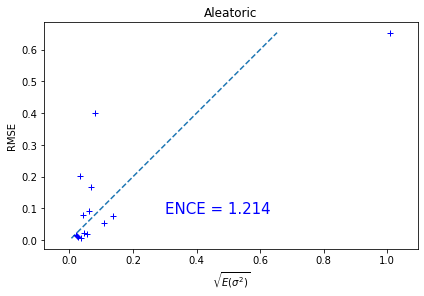

In [204]:
print(f"JAK{par+1}")
plot_error_calibration(y_pred, np.sqrt(y_var_ale), title='Aleatoric')
plot_error_calibration(y_pred, np.sqrt(y_var_epi), title='Epistemic')
plot_error_calibration(y_pred, y_std, title='total')

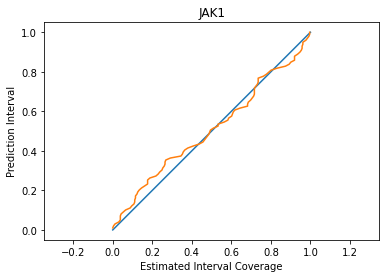

In [205]:
S=len(Langevin_pred)
y_pred_s_lang = np.empty((S, len(test_data)))
for s in range(S):
    y_pred_s_lang[s] = np.random.normal(Langevin_pred[s], Langevin_std[s])

plot_coverage(y_pred_s_lang[2], f"JAK{par+1}")